## **IMPORT**

In [1]:
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *

import os
import pandas as pd

def parse_version_id(version_id):
    major_version = version_id // 3
    major_version_str = 'sequential' if major_version == 0 else ('parallelv' + str(major_version))

    minor_version = version_id % 3
    minor_version_str = 'basic' if minor_version == 0 else 'alphabeta' if minor_version == 1 else 'alphabeta_movesorting'

    return major_version, minor_version, major_version_str + '_minimax_' + minor_version_str + '.py'

def run_command_line(cmd):
    return os.popen(cmd).read()

def handle_output(output, version, version_name, search_depth, results_df = None, ax = None):
    if results_df is None:
        results_df = pd.DataFrame()

    lines = output.split('\n')

    fen            = lines[0][lines[0].find(':') + 2:]
    execution_time = float(lines[1].split()[3])
    score          = float(lines[2].split()[2])
    n_evaluations  = int(lines[3].split()[3])
    encoded_move   = int(lines[4].split()[3])
    
    results_df = pd.concat([results_df, pd.DataFrame({
        'Version'         : [version],
        'Version name'    : [version_name],
        'Search depth'    : [search_depth],
        'Score'           : [score],
        'Execution time'  : [execution_time],
        'No. Evaluations' : [n_evaluations]
    }, index=[results_df.shape[0]])])
    
    if ax is not None:
        game = ChessGame(fen)
        move = decode_move(encoded_move, game.side_to_move())
        game.plot(moves = [move], ax = ax)

    return results_df

def benchmark_minimax(fen, search_depth, versions, plot_moves = True):
    result_df = pd.DataFrame()

    if plot_moves:
        _, axs = plt.subplots(6, 3, figsize = (8 * 3, 8 * 6), squeeze = False)

    for version, version_name in versions.items():
        major, minor, filename = parse_version_id(version)
        command_line = f'python {filename} --fen="{fen}" --search_depth={search_depth}'
        output = run_command_line(command_line)
        result_df = handle_output(output, version, version_name, search_depth, result_df, None if not plot_moves else axs[major, minor])

    return result_df

def benchmark_minimax_multidepth(fen, start_search_depth, versions, time_threshold):
    result_df = pd.DataFrame()

    while len(versions) > 0:
        current_depth_result_df = benchmark_minimax(fen, start_search_depth, versions, plot_moves = False)
        result_df = pd.concat([result_df, current_depth_result_df], ignore_index = True)

        good_versions = current_depth_result_df[current_depth_result_df['Execution time'] <= time_threshold]['Version'].to_list()
        new_versions = {}
        for good_version in good_versions:
            new_versions[good_version] = versions[good_version]
        versions = new_versions

        start_search_depth += 1

    return result_df.sort_values(by = ['Version','Search depth'], ignore_index = True)


## **TESTS**

In [2]:
versions = {
          0: 'Sequential',
          1: 'Sequential + Alpha-beta',
          2: 'Sequential + Alpha-beta + Move sorting',
          3: 'Parallel v1',
          4: 'Parallel v1 + Alpha-beta',
          5: 'Parallel v1 + Alpha-beta + Move sorting',
          6: 'Parallel v2',
          7: 'Parallel v2 + Alpha-beta',
          8: 'Parallel v2 + Alpha-beta + Move sorting',
          9: 'Parallel v3',
         10: 'Parallel v3 + Alpha-beta',
         11: 'Parallel v3 + Alpha-beta + Move sorting',
         12: 'Parallel v4',
         13: 'Parallel v4 + Alpha-beta',
         14: 'Parallel v4 + Alpha-beta + Move sorting',
         15: 'Parallel v5',
         16: 'Parallel v5 + Alpha-beta',
         17: 'Parallel v5 + Alpha-beta + Move sorting',
    }

,Version,Version name,Search depth,Score,Execution time,No. Evaluations
0,0,Sequential,2,-2.7,0.20185,1781
1,1,Sequential + Alpha-beta,2,-2.7,0.04143,309
2,2,Sequential + Alpha-beta + Move sorting,2,-2.7,0.02235,118
3,3,Parallel v1,2,-2.7,0.07467,1781
4,4,Parallel v1 + Alpha-beta,2,-2.7,0.06615,1781
5,5,Parallel v1 + Alpha-beta + Move sorting,2,-2.7,0.08090,1781
6,6,Parallel v2,2,-2.7,0.01505,1781
7,7,Parallel v2 + Alpha-beta,2,-2.7,0.01579,1040
8,8,Parallel v2 + Alpha-beta + Move sorting,2,-2.7,0.00841,118
9,9,Parallel v3,2,-2.7,0.01588,1781


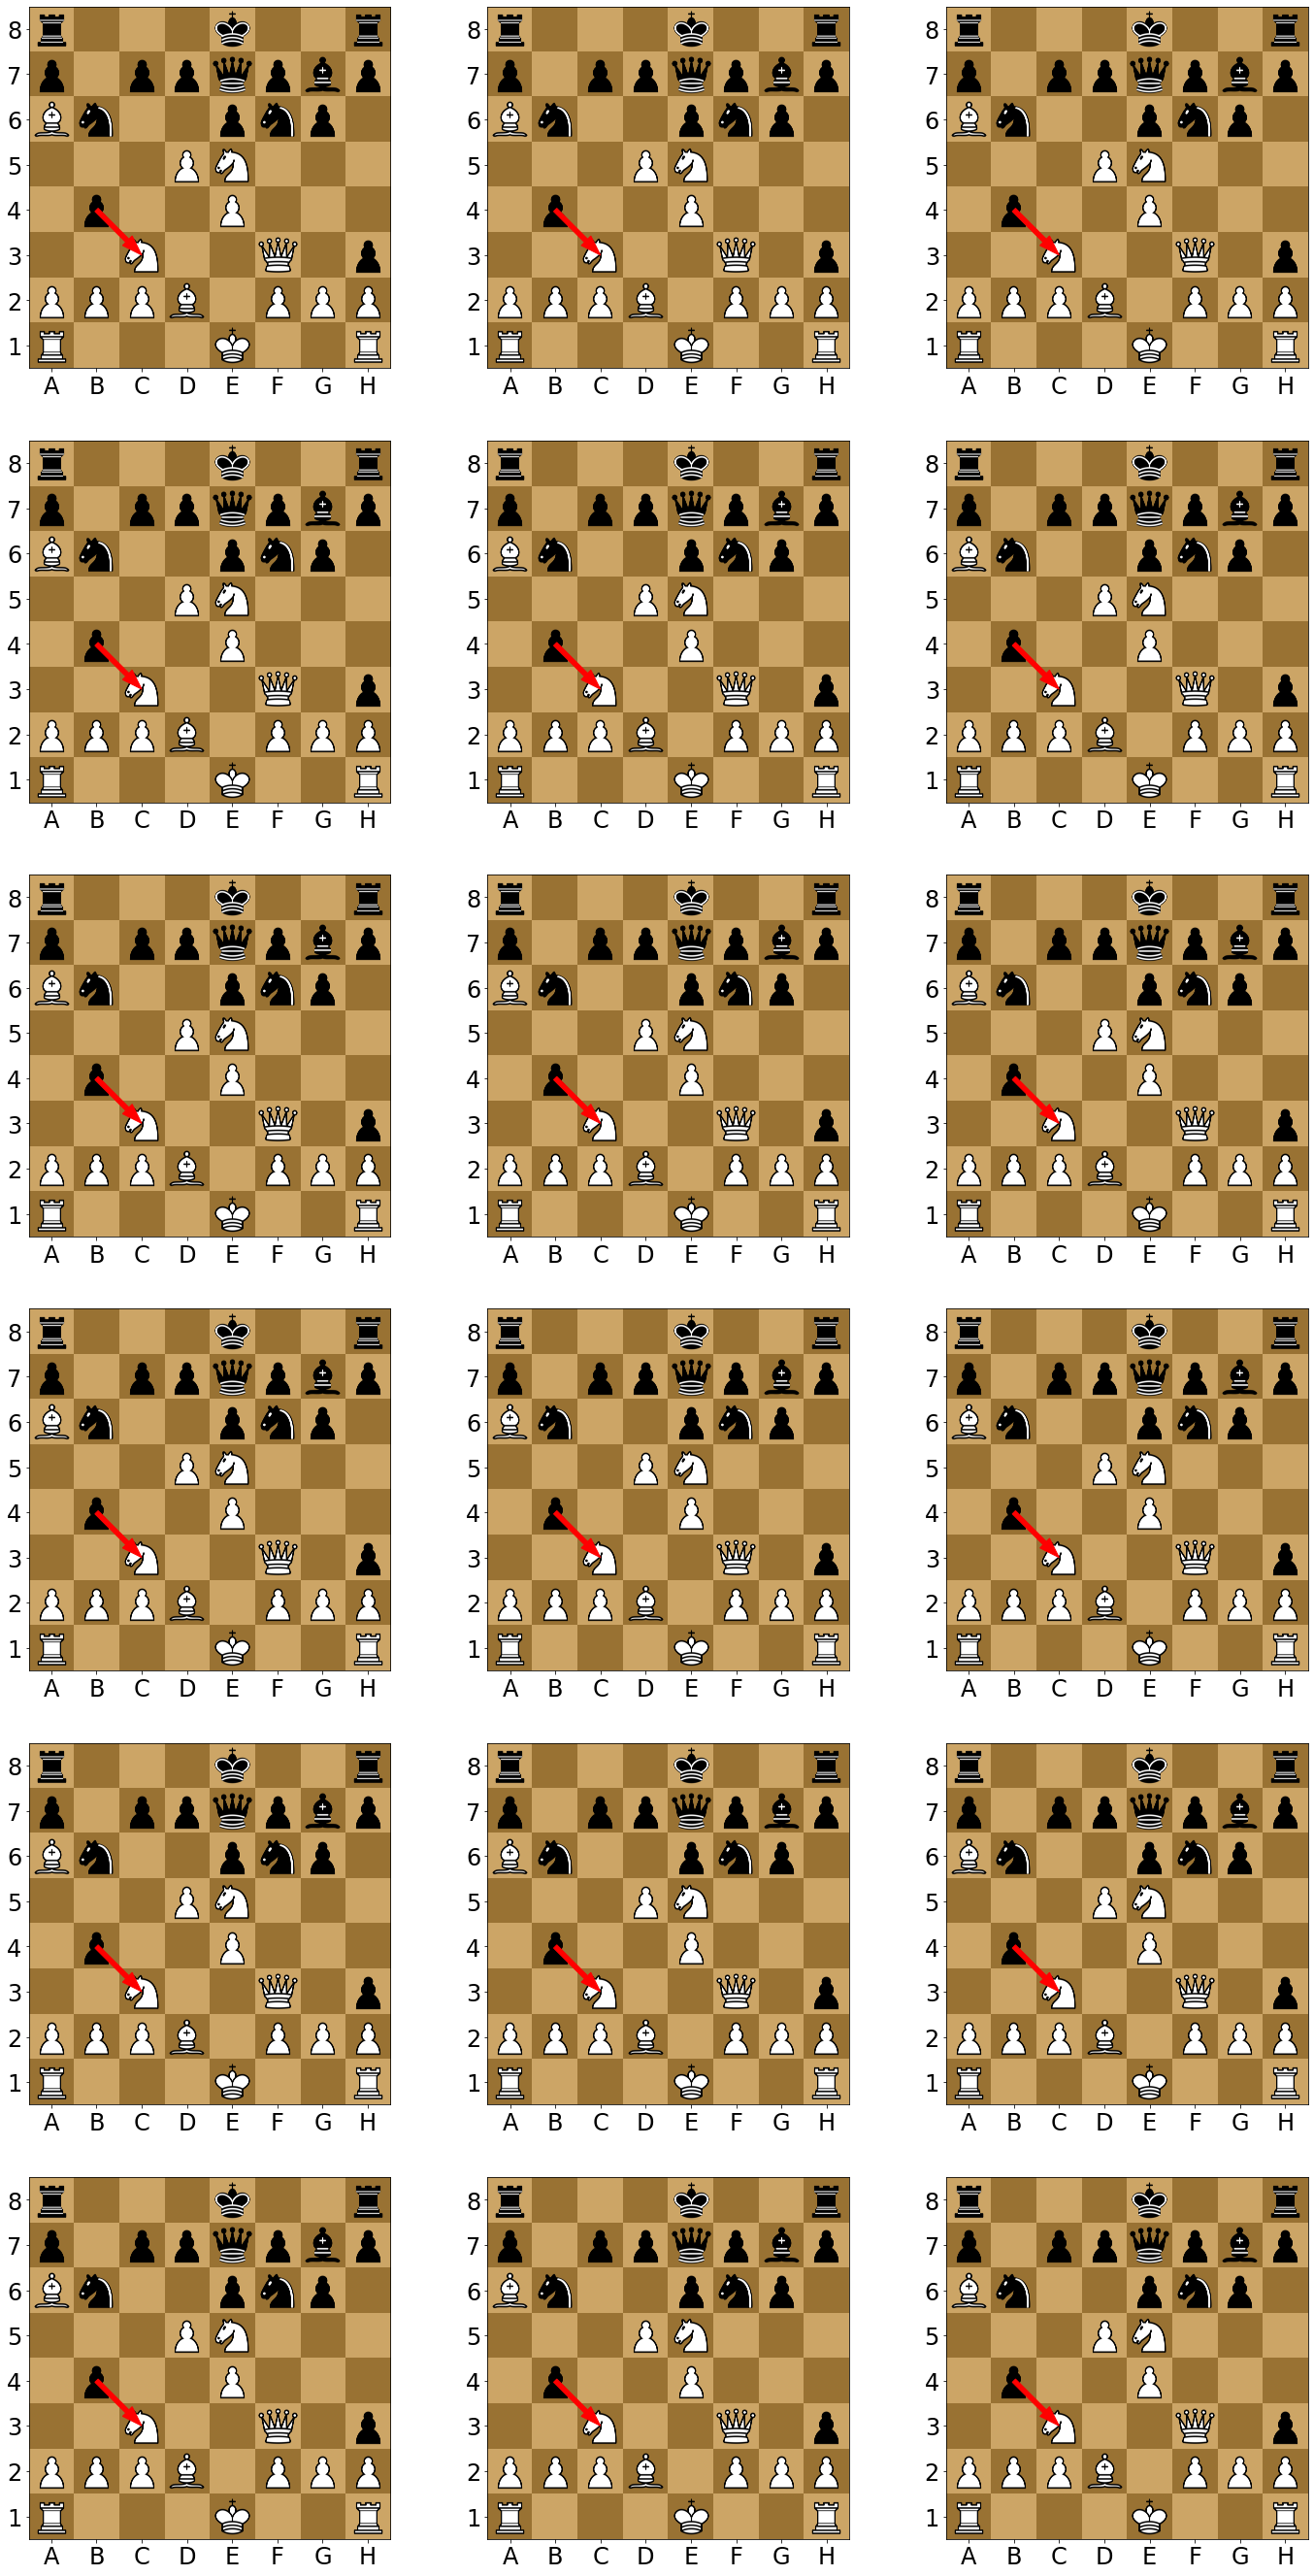

In [3]:
benchmark_minimax('r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1', 2, versions)

In [4]:
result = benchmark_minimax_multidepth('r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1', 2, versions, time_threshold = 10.0)
result.to_csv('benchmark_results_multidepth.csv', index = False)
result

,Version,Version name,Search depth,Score,Execution time,No. Evaluations
0,0,Sequential,2,-2.70,0.21664,1781
1,0,Sequential,3,0.65,6.96226,61320
2,0,Sequential,4,-1.20,361.66696,3107697
3,1,Sequential + Alpha-beta,2,-2.70,0.04186,309
4,1,Sequential + Alpha-beta,3,0.65,0.40939,3212
...,...,...,...,...,...,...
84,17,Parallel v5 + Alpha-beta + Move sorting,3,0.65,0.07167,2937
85,17,Parallel v5 + Alpha-beta + Move sorting,4,-1.20,0.16992,10165
86,17,Parallel v5 + Alpha-beta + Move sorting,5,2.15,0.55403,92974
87,17,Parallel v5 + Alpha-beta + Move sorting,6,-1.00,2.42448,601707


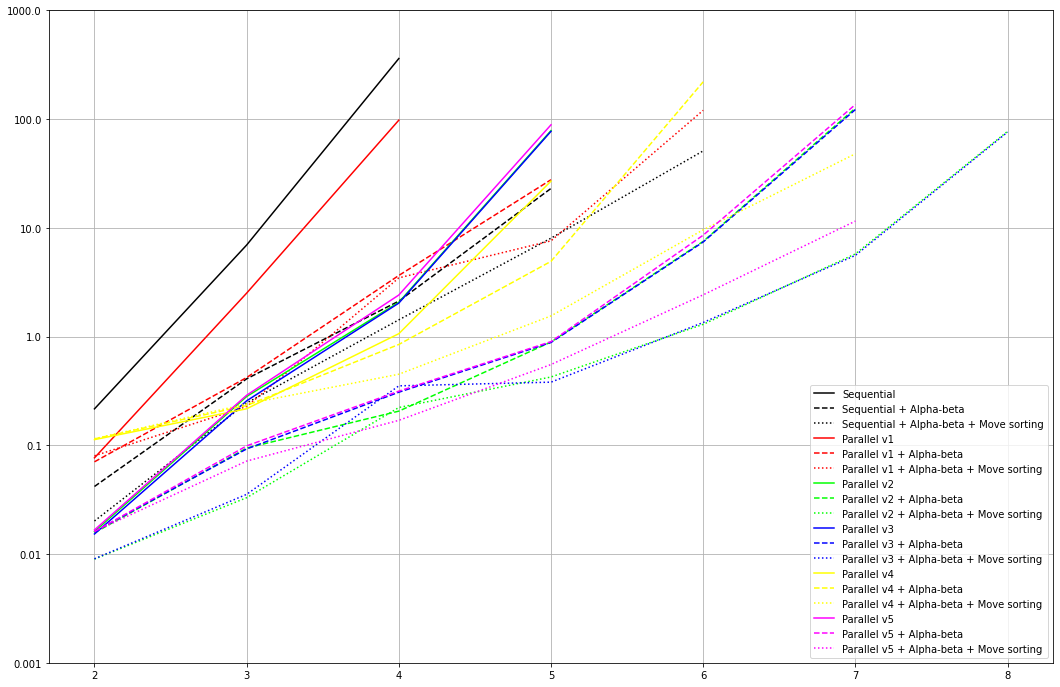

In [5]:
plt.figure(figsize = (18, 12))

colors = [
    '#000000',
    '#ff0000',
    '#00ff00',
    '#0000ff',
    '#ffff00',
    '#ff00ff',
    '#00ffff',
    '#ffffff'
]

styles = [
    'solid',
    'dashed',
    'dotted'
]

for version, version_name in versions.items():
    df = result[result['Version'] == version]
    plt.plot(df['Search depth'], np.log10(df['Execution time']), label = version_name, color = colors[version // 3], linestyle = styles[version % 3])

locs, labels = plt.yticks()
plt.yticks(locs, np.power(10.0, locs))

plt.legend()
plt.grid()
plt.show()